# Survival Analysis of a Cricket Player's Career


#### - Statistical Analysis by Chinmay Dhandhania

## Introduction

Dear SproutsIO,

I have compiled this notebook for your easy viewing from my individual project of last semester. 

The code and data model is based on the game of Cricket, a game that is not very popular in the US. If you get really interested in this model and want to know more about how the game works, you can read it here - https://en.wikipedia.org/wiki/Cricket

#### This notebook is about the application of Survival Analysis in cricket - to analyze the career lengths of players.

* Survival Analysis has been described in length by various resources, the source that inspired and helped me make this project is Chapter 13 in Think Stats - http://greenteapress.com/thinkstats2/thinkstats2.pdf

* Survival Analyisis is used in areas where the time duration of a sample of observations is analysed until an event of **death** occurs.

### Survival Analysis in Cricket
* This is an attempt to extend this statistical concept into the field of cricket - to analyze the career lengths of players.

* The event of death in this case is the event when players retire from active cricket.

* I have tried to analyze all the players who have played cricket. 

<a id='experiment'></a>

## Experiment

- There isn't any readily available data when it comes to cricket yet - ESPNCricinfo (http://www.espncricinfo.com/) still doesn't provide an API to use its StatsGuru (http://stats.espncricinfo.com/ci/engine/stats/index.html) database machine - so I had to scrape the data from the Statsguru webpages to acquire the data.
- This is the scraped URL : http://goo.gl/kbVLNL

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lifelines
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

<a id='scraping'></a>

### Scraping
Writing the code to scrape the important data from the url page.

In [2]:
mycricketurl = 'http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=runs;page=1;size=200;template=results;type=batting'

In [3]:
def scrape_data(page_count):
    """
    scrapes the required data present in the form of a table from the given url
    :param url: page of the ESPNCricinfo Stats URL query
    :return: the raw unicode text
    """
    url = mycricketurl
    complete_url = url.partition('page=1')[0] + "page=" + str(page_count) + url.partition('page=1')[-1]
    r = requests.get(complete_url)
    data = r.text
    soup = BeautifulSoup(data)
    table = soup.find_all('table')
    return table[2].text

<a id='data_cleaning'></a>

### Data Cleaning
I am now removing all the whitespace and noise from the data

In [4]:
def clean_data(text):
    
    text = text.split('\n')
    text.remove(u'Overall figures')
    return text

<a id='data_transformation'></a>

### Data Transformation


I am now converting the text into a dataframe and making it readable

In [5]:
def create_data():
    """
    scrapes the data, cleans it and transforms the data to load into a pandas dataframe
    """
    page_count = 12
    df = pd.DataFrame()
    get_list_columns = lambda text, start_index, end_index: [str(unicode_text)
                                                                for unicode_text in text][start_index:end_index]
    get_data_rows = lambda text, start_index: text[start_index:]
    remove_all_occurences = lambda data, item: [x for x in data if x != item]
    get_list_rows = lambda data: [data[index: index + 13] for index, row in enumerate(data) if index % 13 == 0]
    for page in range(1, page_count + 1):
        raw_text = scrape_data(page)
        clean_text = clean_data(raw_text)
        list_columns = get_list_columns(clean_text, 3, 16)
        data_rows = get_data_rows(clean_text, 16)
        data_rows = remove_all_occurences(data_rows, u'')
        list_rows = get_list_rows(data_rows)
        df_new = pd.DataFrame(list_rows, columns=list_columns)
        if len(df) == 0:
            df = df_new
        else:
            df = pd.concat([df, df_new])
    return df

In [6]:
df_full = create_data()
df_full = df_full.reset_index(drop=True)

C:\Anaconda2\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Now saving the data to a csv file for consistency and ease

In [7]:
df_full.to_csv('cricinfo_oct2.csv')

In [8]:
len(df_full)

2280

* There are totally 2280 players who have played cricket at the international level

Check out the sample of the data for better understanding the rest of the project.

In [9]:
df_full.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (India),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (Aus/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


Renaming the columns to access them easier

In [10]:
df_full.columns = ['player', 'span', 'mat', 'inns', 'not_outs', 'runs', 'high_score', 'ave', 'bf', 'sr', 'n_100', 'n_50', 'n_0']

* Since the variable we require is the length of the player's career,we extract only two columns - the name of the player and the span(duration of career) from the original dataframe.

In [11]:
dataf_span = df_full[['player','span']]

In [12]:
dataf_span.head()

,player,span
0,SR Tendulkar (India),1989-2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015
2,RT Ponting (Aus/ICC),1995-2012
3,ST Jayasuriya (Asia/SL),1989-2011
4,DPMD Jayawardene (Asia/SL),1998-2015


Information required for further analysis:
       - Career start date
       - Career end date
       - Country
   The reason being, the players can be grouped into cohorts and the survival curve of these cohorts can be compared to find any insights.

* Creating additional columns - 'career start date' and 'career end date' to 

In [13]:
# disables warning
pd.options.mode.chained_assignment = None
dataf_span['career_starting_at'] = [int(span.partition('-')[0]) for span in dataf_span.span]
dataf_span['career_ending_at'] = [int(span.partition('-')[-1]) for span in dataf_span.span]

In [14]:
dataf_span.head()

,player,span,career_starting_at,career_ending_at
0,SR Tendulkar (India),1989-2012,1989,2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015
2,RT Ponting (Aus/ICC),1995-2012,1995,2012
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015


Adding another column - 'career_length' which is obtained from subtracting the above two columns

In [15]:
length_of_career = lambda df: [row.career_ending_at - row.career_starting_at + 1 for index, row in df.iterrows()]
dataf_span['career_length'] = length_of_career(dataf_span)

In [16]:
dataf_span.head()

,player,span,career_starting_at,career_ending_at,career_length
0,SR Tendulkar (India),1989-2012,1989,2012,24
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18


The country of the player has not been represented, though it has been included within the player's name. Having 
the country as a column can be quite useful.

In [17]:
get_name = lambda player : [every_player.partition(' (')[0] for every_player in player]
dataf_span['name'] = get_name(dataf_span.player)

In [18]:
get_country = lambda player: [every_player[every_player.index('(')+1:every_player.index(')')] for every_player in player]
dataf_span['country'] = get_country(dataf_span.player)

* Certain players however have played for more than 1 team - Asia/ ICC etc. Such countries don't make any change and
have to be removed.
* Certain players like Kepler Wessels, Eoin Morgan have played for more than 1 country - for sake of simplicity, 
such players are ignored as their career lengths will be longer - forming outliers.

In [19]:
remove_forward_slash = lambda country: [every_country.replace('/', '') for every_country in country]
dataf_span['country'] = remove_forward_slash(dataf_span.country)

Considering players belonging to the 'Full members' of ICC as the associate countries' data may be noisy, creating outliers

In [20]:
list_countries = lambda country : ['India' if 'India' in every_country
                 else 'SL' if 'SL' in every_country
                 else 'SA' if 'SA' in every_country
                 else 'Aus' if 'Aus' in every_country
                 else 'Pak' if 'Pak' in every_country
                 else 'WI' if 'WI' in every_country
                 else 'NZ' if 'NZ' in every_country
                 else 'Zim' if 'Zim' in every_country
                 else 'Eng' if 'Eng' in every_country
                 else 'Ban' if 'Ban' in every_country
                 else None for every_country in country]
dataf_span['country'] =  list_countries(dataf_span.country)

In [21]:
dataf_span = dataf_span[dataf_span.country.notnull()]

In [22]:
dataf_span.head()

,player,span,career_starting_at,career_ending_at,career_length,name,country
0,SR Tendulkar (India),1989-2012,1989,2012,24,SR Tendulkar,India
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16,KC Sangakkara,SL
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18,RT Ponting,Aus
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23,ST Jayasuriya,SL
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18,DPMD Jayawardene,SL


Dropping columns 'player' and 'span' from the dataframe

In [23]:
dataf_span = dataf_span.drop('player', 1)

In [24]:
dataf_span = dataf_span.drop('span', 1)

Reordering the columns

In [25]:
dataf_span = dataf_span[['name', 'country', 'career_starting_at', 'career_ending_at', 'career_length']]

In [26]:
dataf_span.head()

,name,country,career_starting_at,career_ending_at,career_length
0,SR Tendulkar,India,1989,2012,24
1,KC Sangakkara,SL,2000,2015,16
2,RT Ponting,Aus,1995,2012,18
3,ST Jayasuriya,SL,1989,2011,23
4,DPMD Jayawardene,SL,1998,2015,18


<a id='censoring_data'></a>

## Censoring the data

In [27]:
# entering 1 intially for all players
dataf_span['censor'] = [1 if every_player.career_ending_at <= 2011 else 0 for index,every_player in dataf_span.iterrows()]

* censor label : 1 means that player has retired, 0 means that the player has an active playing career.

In [28]:
#re-ordering index of dataframe
dataf_span.reset_index(drop=True);

In [29]:
# converting dataframe to csv to manually alter it
dataf_span.to_csv('censor_oct2.csv')

In [30]:
dataf_censor = pd.read_csv('censor_oct2.csv')

In [31]:
dataf_censor = dataf_censor.drop('Unnamed: 0', 1);

In [32]:
dataf_censor.head()

,name,country,career_starting_at,career_ending_at,career_length,censor
0,SR Tendulkar,India,1989,2012,24,0
1,KC Sangakkara,SL,2000,2015,16,0
2,RT Ponting,Aus,1995,2012,18,0
3,ST Jayasuriya,SL,1989,2011,23,1
4,DPMD Jayawardene,SL,1998,2015,18,0


The following data shows few rows of the data with its censored values.

In [33]:
dataf_censor.tail(12)

,name,country,career_starting_at,career_ending_at,career_length,censor
1760,EP Thompson,NZ,2009,2009,1,1
1761,AL Thomson,Aus,1971,1971,1,1
1762,RW Tolchard,Eng,1979,1979,1,1
1763,CM Tuckett,WI,1998,1998,1,1
1764,I Udana,SL,2012,2012,1,0
1765,JD Unadkat,India,2013,2013,1,0
1766,JM Vince,Eng,2015,2015,1,0
1767,Wahidul Gani,Ban,1988,1988,1,1
1768,KP Walmsley,NZ,2003,2003,1,1
1769,M Watkinson,Eng,1996,1996,1,1


In [34]:
dataf_censor.censor.value_counts().sort_index()

0     419
1    1353
Name: censor, dtype: int64

Therefore, there are 419 players whose careers are still active and 1353 players who have retired.

In [35]:
dataf_censor.head()

,name,country,career_starting_at,career_ending_at,career_length,censor
0,SR Tendulkar,India,1989,2012,24,0
1,KC Sangakkara,SL,2000,2015,16,0
2,RT Ponting,Aus,1995,2012,18,0
3,ST Jayasuriya,SL,1989,2011,23,1
4,DPMD Jayawardene,SL,1998,2015,18,0


<a id='plot_survival_curve'></a>

## Plotting the survival curve

In [36]:
from lifelines import KaplanMeierFitter
kapmf = KaplanMeierFitter()

In [37]:
kapmf.fit(dataf_censor.career_length, event_observed=dataf_censor.censor)

<lifelines.KaplanMeierFitter: fitted with 1772 observations, 419 censored>

In [38]:
import plotly
import plotly.tools as tls
import plotly.plotly as py
from plotly.graph_objs import Figure, Data, Layout
import matplotlib.pyplot as plt
from plotly.graph_objs import *
%matplotlib inline
from pylab import rcParams

In [39]:
def pyplot(fig, ci=True, legend=True):
    # Convert mpl fig obj to plotly fig obj, resize to plotly's default
    py_fig = tls.mpl_to_plotly(fig, resize=True)
    
    # Add fill property to lower limit line
    if ci == True:
        style1 = dict(fill='tonexty')
        # apply style
        py_fig['data'][2].update(style1)
        
        # Change color scheme to black
        py_fig['data'].update(dict(line=Line(color='black')))
    
    # change the default line type to 'step'
    py_fig['data'].update(dict(line=Line(shape='hv')))
    # Delete misplaced legend annotations 
    py_fig['layout'].pop('annotations', None)
    
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            legend=Legend(
                x=1.05,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return py.iplot(py_fig)

In [40]:
p = kapmf.plot(ci_force_lines=True, title='Career span of cricket players')
kapmf1 = plt.gcf()
pyplot(kapmf1)

C:\Anaconda2\lib\site-packages\plotly\matplotlylib\renderer.py:384: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

C:\Anaconda2\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



<a id='survival_curve_observations'></a>

### Observations

In [41]:
kapmf.median_

6.0

* It is observed that the probablity of the population having career of atleast 6 years is 50%. 

In [42]:
kapmf.survival_function_.KM_estimate[20]

0.01353478428238764

* On the other hand, there is 1.3 % chances that a player's career will extend beyond 20 years.

In [43]:
kapmf.survival_function_.KM_estimate[10]

0.26502884824883655

* There is 26.5% chance that a player's career extends beyonds 10 years

<a id='plot_country-cohorts'></a>

## Plotting using Cohorts - Further Analysis

<a id='comp_ind_aus'></a>

### Case 1:  Comparing India and Australia

In [44]:
cnt_typetype = dataf_censor['country'].unique()

In [45]:
ind = dataf_censor.query('country == "India"')

In [46]:
aus = dataf_censor.query('country == "Aus"')

In [47]:
from lifelines import KaplanMeierFitter
kapmf = KaplanMeierFitter()
ax = plt.subplot(111)
kapmf.fit(ind.career_length, event_observed=ind.censor, label="India")
kapmf.survival_function_.plot(ax=ax)
kapmf.fit(aus.career_length, event_observed=aus.censor, label="Aus")
kapmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among India and Australia players ")
kapmf2 = plt.gcf()
pyplot(kapmf2, ci=False)

C:\Anaconda2\lib\site-packages\plotly\matplotlylib\renderer.py:516: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



<a id='ind_aus_obs_inf'></a>

#### Observations:
* There are primarily two trends observed in the plots - 
    1. The survival curve for Australia is more than that of India between the period, 3 to 10 years.
    2. The survival curve for India dominates that of Australia from 10 years.
* The tail for Australia ends at around 17 years while for India, it extends much longer (till 24 years).

<a id='comp_pak_eng'></a>

### Case 2: Comparing Pakistan and England

In [48]:
pak = dataf_censor.query('country == "Pak"')

In [49]:
eng = dataf_censor.query('country == "Eng"')

In [50]:
from lifelines import KaplanMeierFitter
kapmf = KaplanMeierFitter()
ax = plt.subplot(111)
kapmf.fit(pak.career_length, event_observed=pak.censor, label="Pak")
kapmf.survival_function_.plot(ax=ax)
kapmf.fit(eng.career_length, event_observed=eng.censor, label="Eng")
kapmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among England and Pakistan players ")
kapmf2 = plt.gcf()
pyplot(kapmf2, ci=False)

<a id='pak_eng_obs_inf'></a>

#### Observations:
* The survival curve for both the countries seem to be almost the same till 5 years. 
* After that point, we notice that the curve seem to significantly higher for Pakistan than England.
* The survival curve continues past the duration of 20 years for India (around 22) but it tapers off for England
    at 20 itself.

#### Inferences:
* The chance of players from the sample, have a career more than 5 years is 50% for both the countries. 
* But the chance of a player from Pakistan having a career more than 10 years is around 30% whereas there's only 20% chance of a player from England having a career more than 10 years. 
* The difference becomes more conspicious when we note the chances of a player having a career more than 12-13 years.
* We notice that the probability(or chance) is approximately double in the case of Pakistan when compared to that England. 

** In other words, a player representing Pakistan is twice more likely of having a career more than 12-13 years than a player from England!**

### Plotting all the countries

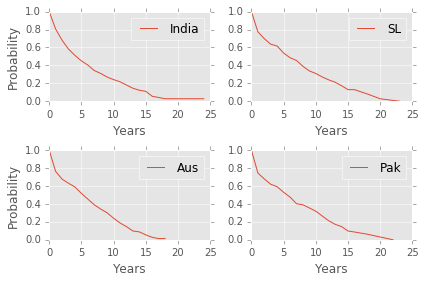

In [51]:
for i,cnt_type in enumerate(cnt_typetype[:4]):
    ax = plt.subplot(2,2,i+1)
    kapmf1 = KaplanMeierFitter()
    ind = dataf_censor[dataf_censor.country == cnt_type]
    kapmf1.fit(ind.career_length, event_observed=ind.censor, label=cnt_type)
    kapmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

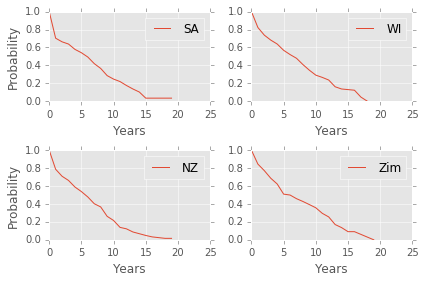

In [52]:
for i,cnt_type in enumerate(cnt_typetype[4:8]):
    ax = plt.subplot(2,2,i+1)
    kapmf1 = KaplanMeierFitter()
    ind = dataf_censor[dataf_censor.country == cnt_type]
    kapmf1.fit(ind.career_length, event_observed=ind.censor, label=cnt_type)
    kapmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

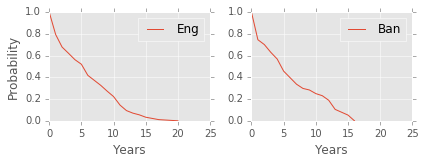

In [53]:
for i,cnt_type in enumerate(cnt_typetype[8:]):
    ax = plt.subplot(2,2,i+1)
    kapmf1 = KaplanMeierFitter()
    ind = dataf_censor[dataf_censor.country == cnt_type]
    kapmf1.fit(ind.career_length, event_observed=ind.censor, label=cnt_type)
    kapmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

In [54]:
ax = plt.subplot(111)
kapmf = KaplanMeierFitter()
for country in cnt_typetype:
    df_country = dataf_censor[dataf_censor.country == country]
    kapmf.fit(df_country.career_length, df_country.censor, label=country)
    ax = kapmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers across all countries ")
kapmf2 = plt.gcf()
pyplot(kapmf2, ci=False)    

<a id='plot_era-cohorts'></a>

## Plotting using eras

* The players are divided into 3 main 'eras', based on when they made their debut:
    1. 2007 - present
    2. 1989 - 2006
    3. Start of ODI cricket - 1988

In [55]:
type_era = []
for index, row in dataf_censor.iterrows():
    if row.career_starting_at < 1989:
        type_era.append('0')
    if row.career_starting_at >= 1989 and row.career_starting_at < 2007:
        type_era.append('1')
    if row.career_starting_at >= 2007:
        type_era.append('2')
dataf_censor['type_era'] = pd.Series(type_era)

* Plotting the players, based on their eras.

In [56]:
from lifelines import KaplanMeierFitter
era_0 = dataf_censor.query("type_era == '0'")
era_1 = dataf_censor.query("type_era == '1'")
kapmf = KaplanMeierFitter()
ax = plt.subplot(111)
kapmf.fit(era_0.career_length, event_observed=era_0.censor, label="before 89")
kapmf.survival_function_.plot(ax=ax)
kapmf.fit(era_1.career_length, event_observed=era_1.censor, label="89-07")
kapmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among players who made their debut before 89 and 89 -'07 ")
#plt.title("Survival curve of ODI Careers among England and Pakistan players ")
kapmf2 = plt.gcf()
pyplot(kapmf2, ci=False)

<a id='era_obs_inf'></a>

#### Observations:
* The basic trend observed in the plot - 
    The survival curve for the players who made their debut in the period 89-2007 clearly dominates the players who made their debut before 1989 from the period, 5 years to the end - the domination is evident especially from 9 years.

#### Inferences:
* There is a greater chance for players who made their debut in the period 89-2007 to have a career length of 9 years and more than players who made their debuts before 1989.

<a id='era_inf_sport'></a>

### Can this be explained by the sport itself?

* The sport has changed drastically from the 1980s to present. 
* Health facilities and fitness training has improved drastically with technology. 
* This probably can lengthen a player's career - especially when he has played for around 10 years or so. The improved facilities/standards can help him get back to competitive cricket quicker than it has been earlier. This probably explains the dominance of the curve from 9 years.

<a id='plot_player-cohorts'></a>

## Survival Regression

* The concept of survival analysis can be used to predict the survival curves of individual subjects too. This is achieved by using regression models.

* These regression models regress the covariates( additional information obtained related to the subject) against the duration and censor information of the subject. 

* The regression models - Aalen's Additive Model and Cox's Proportional Hazards Model, estimate the hazard rate.  

* Survival Regression can be used to predict the individual survival and hazard rates. 

* These regression techniques can thus be applied on  individual players, whose career is not oer yet, to predict the possible lifetime of his career.

* The covariates used are:
    1. Country
    2. Era the player belongs to
    3. Role of player

* Using these covariates, the individual survival rates can be estimated by regressing these covariates against the known duration and censoring information.

* The Aalen Additive model is used on this dataset.

In [57]:
from lifelines import AalenAdditiveFitter

In [58]:
import pandas as pd
df_regression = pd.read_csv('censor_oct2.csv')
df_regression = df_regression.drop('Unnamed: 0', 1);
type_era = []
for index, row in df_regression.iterrows():
    if row.career_starting_at < 1989:
        type_era.append('0')
    if row.career_starting_at >= 1989 and row.career_starting_at < 2007:
        type_era.append('1')
    if row.career_starting_at >= 2007:
        type_era.append('2')
df_regression['type_era'] = pd.Series(type_era)


In [59]:
import patsy
X = patsy.dmatrix('country + type_era -1', df_regression, return_type='dataframe')
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
X['T'] = df_regression.career_length
X['E'] = df_regression.censor
aaf.fit(X, 'T', event_col='E')

 [-----------------100%-----------------] 1353 of 1353 complete in 0.9 sec


<lifelines.AalenAdditiveFitter: fitted with 1772 observations, 419 censored>

<a id='predict_kohli'></a>

### Predict the survival rate of Virat Kohli

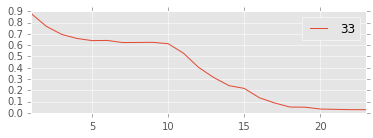

In [60]:
ix = (dataf_censor['name'] == 'V Kohli')
kohli = X[ix]
ax = plt.subplot(2,1,2)
aaf.predict_survival_function(kohli).plot(ax=ax)

<a id='predict_steyn'></a>

### Predict the survival rate of Dale Steyn

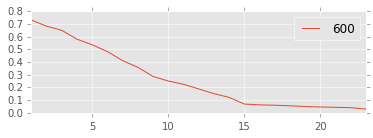

In [61]:
ix = (dataf_censor['name'] == 'DW Steyn')
steyn = X[ix]
ax = plt.subplot(2,1,2)
aaf.predict_survival_function(steyn).plot(ax=ax)

<a id='caveats_regression'></a>

###  Weakness of this model

* This model takes only 3 factors into concern : 
    1. Country
    2. Era the player belongs to
    3. Role of player


* There are many other factors that affect the career of the player, such as health, injury, consistency, dedication, honesty in playing the game (not getting banned), etc.


* However, these factors are not quantifiable and even if they are, it is very difficult to generate such data for all the players.


* Under these limitations of the model, it may look like for example, any Indian batsman who makes his debut after 2007 will have the same survival rate as that of  Virat Kohli.


* But if further factors are taken into concern, then the survival rates will be very different and can be more useful.